# Hyperparameter optimization

In machine learning hyperparameter optimization is the process of finding a set of optimal hyperparameters for a machine learning model. Hyperparameters need to be distinguished from model's parameters. Model's parameters are set by the learning algorithm during the training process, while hyperparameters are set by engineers or developers before initiating the training. In practice, we usually look for a set of hyperparameters that minimize the loss function:

$$
x_{*} = argmin \; f(x),
$$

where $f(x)$ is the function which we are trying to minimize (usually the loss function) and $x_{*}$ is the optimal setup of the hyperparameter vector that we are looking for.

It is important to note here that $f(x)$ has some characteristics that make this work tedious:

* $f(x)$ is indifferentiable in regards to $x$, which means that gradient based techniques are off the table.
* It takes a long time to compute the value of $f(x)$ for a given value of $x$, meaning that is extremely expensive to calculate the value of $f(x)$ for a lot of different inputs.
* From our perspective $f(x)$ is more or less a black box that we can probe only a couple of times.

A practical example of this process would be training a deep neural network for a regression task where we use mean squared error (MSE) as our loss function. Let us assume that the training process takes around 10 hours, during training the learning algorithm will find a set of weights and biases that minimizes the loss function. However, there are a bunch of hyperparameters that also influence the quality of the model (the loss function) and those need to be set by the engineer, to name a few: learning rate, batch size, optimizer, network architecture ... Each of these hyperparameters has many values and testing all combinations is infeasible as testing a single combination takes 10 hours. We can alleviate this by testing only a subset of hyperparameters, the scientific field of hyperparameter optimization tries to find methods for getting an optimal set of hyperparameters as quickly as possible.

So, one might look at the problem of hyperparameter optimization as a problem of finding a set of hyperparameters that minimizes the loss function. For the purpose of this lecture we will create a toy loss function which means that we know exactly what it looks like in regards to our hyperparameter. Next, we will try finding the optimal value for the hyperparameter by using different hyperparameter optimization techniques.

The code block below defines the shape of our loss function, we are interested in finding the value of our hyperparmeter $x$ that minimizes this function on the [0, 3] interval.

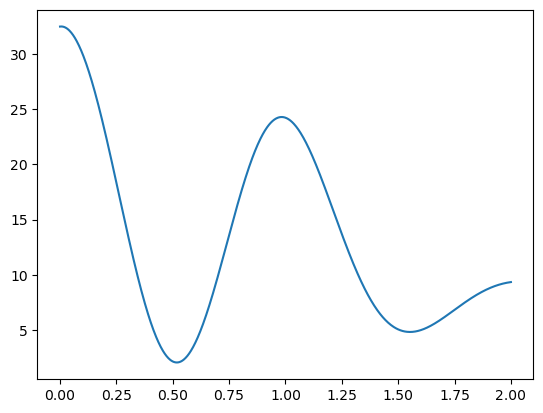

In [102]:
import math
import numpy as np
import matplotlib.pyplot as plt

def loss_function(x, print_value = False):
    """
    A random toy loss function.

    Parameters:
        x (float): the input value
        print_value (bool): whether to print the value of the loss function
    """
    value = 3 * x + (1 - 1 / 3 * math.sin(12 * x + 3) / (10 + x) + (8 * math.cos(3 * x)) ** 2) / (x ** 4 + 2)
    if print_value:
        print(f"loss_function({x}) = {value}")
    return value

# plot the loss function from 0 to 2
start = 0
end = 2
x_loss = np.linspace(start, end, 1000)
y_loss = [loss_function(i) for i in x_loss]
plt.plot(x_loss, y_loss)

As you can see the optimal setting for our hyperparameter $x$ is somewhere around 1.6. For the sake of this lecture, we will assume that we can only afford to evalute $f(x)$ (train our model) 10 times. The first method we will talk about is called manual search.

## Manual search

We will only briefly mention this method as it is not the most transparent and reproducible. The logic here is that the engineer tries a couple of values and somehow imagines the shape of the loss function in his head. After that the engineer uses his intuition and expertise to move around and explore that space in an educated manner. Obviously, this is suboptimal and not completely reproducible by other engineers. But this approach is often used in the ideation/exploration phase to get some kind of a feeling about how various hyperparameters influence our model's training. But when looking for the optimal set of hyperparameters this approach is usually discarded and other, more systematic techniques take its place. Below is a (silly) example about how one might use this technique to find the optimal $x$ in our use case.

loss_function(0) = 32.49764799986567
loss_function(2) = 9.332042260079362
loss_function(1) = 24.235247826895243
loss_function(1.5) = 5.040825590317427
loss_function(1.75) = 6.815045715217691
loss_function(1.625) = 5.174949327105409
loss_function(1.55) = 4.809262183470919
loss_function(1.525) = 4.86952922541952
loss_function(1.53) = 4.848940155766878
loss_function(1.56) = 4.81372098643218

min x manual = 1.55


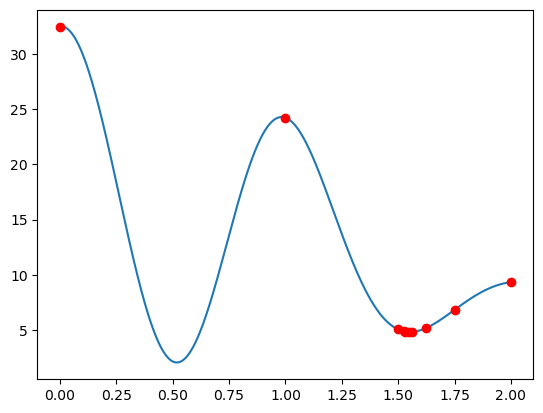

In [105]:
# let's start at the beginning
x_manual = []
y_manual = []

# let's start at 0
x = 0
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# let's try the other end
x = 2
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# let's try in between
x = 1
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# now it is larger, let's look at 1.5
x = 1.5
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# looking good, keep going
x = 1.75
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.625
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.55
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.525
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.53
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.56
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# find minimum y_manual and it's x_manual
min_y_manual = min(y_manual)
min_x_manual = x_manual[y_manual.index(min_y_manual)]
print(f"\nmin x_manual = {min_x_manual}")

# plot loss_function from above along with x_manual and y_manual points
plt.plot(x_loss, y_loss)
plt.plot(x_manual, y_manual, 'ro')

There, by moving around with some kind of a manual "pedestrian gradient descent" we reached the value $x = 0.57$, as we can see from the figure above, this is not really the global optimum and there are a bunch of better values. This is a silly illustration where we have a single dimension (single hyperparameter), you can imagine that this becomes even worse in higher dimensions where hyperparameters might also interact.

## Grid search

Also called parameter sweep, is probably the most traditional method for peforming hyperparmaeter optimization. For each of the hyperparameters we define a discrete subset of values we would like to explore and then test all combinations. As expected, the sparsity of the grid increases as we have more and more parameters, since we can usually test only a small amount of all possible combinations, we have to reduce the resolution of our search protocol in order to retain a feasible amount of combinations.

In our case, when we have only a single hyperparameter we will be able to test values of $x$ that are approximately 0.22 units away from each other. If we had another parameters, say $x_2$, we would have to decrease the $x$ resolution in order to remain within the 10 managable tests. With two hyperparameters we could only test 5 values of $x$ and 2 values of $x_2$ for example. This outlines the main issue with grid search, it does not really scale that well. Because of this, we often have to set constant values to some hyperparameters and only explore how a small subset of everything we can tune influences the final result.

Below is an example of grid search on our toy example:


testing x values: [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.        ]

loss_function(0.0) = 32.49764799986567
loss_function(0.2222222222222222) = 20.9152054084862
loss_function(0.4444444444444444) = 3.5467669278825875
loss_function(0.6666666666666666) = 7.5128480895047725
loss_function(0.8888888888888888) = 22.325441383201987
loss_function(1.1111111111111112) = 21.122924534346783
loss_function(1.3333333333333333) = 9.491643186499566
loss_function(1.5555555555555554) = 4.809820670203196
loss_function(1.7777777777777777) = 7.225444232073645
loss_function(2.0) = 9.332042260079362

min x_grid = 0.4444444444444444


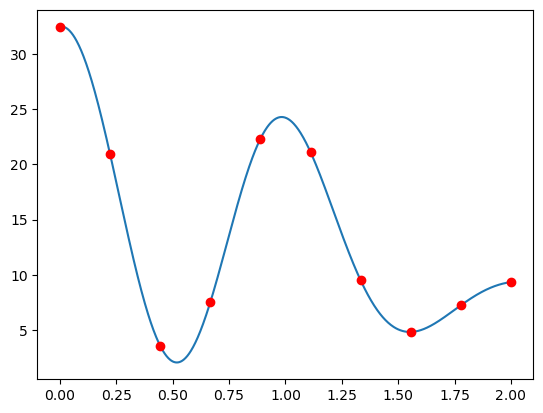

In [125]:
# create the grid
x_interval = np.linspace(start, end, 10)
print(f"testing x values: {x_interval}\n")

# train on all values in the grid
x_grid = []
y_grid = []
for x in x_interval:
    x_grid.append(x)
    y_grid.append(loss_function(x, print_value=True))

# find minimum y_grid and it's x_grid
min_y_grid = min(y_grid)
min_x_grid = x_grid[y_grid.index(min_y_grid)]
print(f"\nmin x_grid = {min_x_grid}")

# plot loss_function from above along with x_grid and y_grid points
plt.plot(x_loss, y_loss)
plt.plot(x_grid, y_grid, 'ro')

As you can see, grid search found a quite decent value at $x = 0.4444$. However, there are still better values to be found. The next approach that we will take a look at is called random search.

## Random search

Random Search replaces the exhaustive enumeration of all defined combinations by selecting them randomly, meaning that we can define a larger amount of combinations and then test only a subset of them through random selection. A benefit over grid search is that random search can explore many more values than grid search could for continuous hyperparameters. It can outperform grid search, especially when only a small number of hyperparameters affects the final performance of the machine learning algorithm. In this case, the optimization problem is said to have a low intrinsic dimensionality. Random search also allows the inclusion of prior knowledge by specifying the distribution from which to sample.

testing x values: [1.43980031 0.20028823 1.17929547 1.20001112 1.12133706 0.62160777
 1.60661578 0.85989676 0.69545481 0.77786266]

loss_function(1.4398003118087739) = 5.96401122280794
loss_function(0.20028822616694186) = 22.867465222482377
loss_function(1.1792954650764542) = 17.643528337513843
loss_function(1.2000111185380495) = 16.486448394888974
loss_function(1.1213370628277664) = 20.65118392427659
loss_function(0.6216077708192369) = 4.843594661547627
loss_function(1.6066157809443622) = 5.021211524774904
loss_function(0.8598967573308127) = 20.960471452651753
loss_function(0.6954548114405366) = 9.511080816443686
loss_function(0.7778626556742569) = 15.672268708416153

min x_grid = 0.6216077708192369


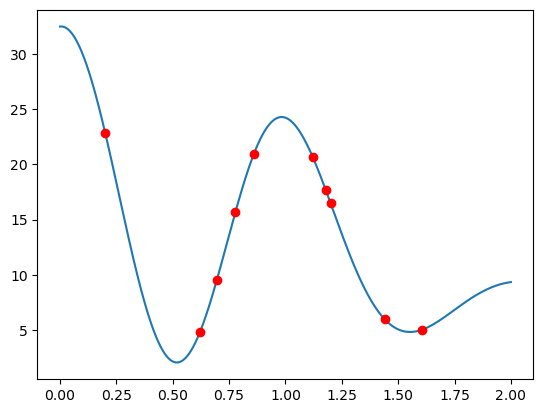

In [134]:
# get 10 random values from 0 to 2
x_interval = np.random.uniform(start, end, 10)
print(f"testing x values: {x_interval}\n")

# train on all values in the grid
x_random = []
y_random = []
for x in x_interval:
    x_random.append(x)
    y_random.append(loss_function(x, print_value=True))

# find minimum y_grid and it's x_grid
min_y_random = min(y_random)
min_x_random = x_random[y_random.index(min_y_random)]
print(f"\nmin x_grid = {min_x_random}")

# plot loss_function from above along with x_random and y_random points
plt.plot(x_loss, y_loss)
plt.plot(x_random, y_random, 'ro')

Well, random is random so the end results is left to chance. While we probably won't get an optimal result, we usually get a decent result. As always, increasing the number of combinations we try should give better results in the long term. The next set of algorithm for hyperparameter optimizations is called evolutionary optimization.

## Evolutionary optimization

Evolutionary optimization falls into the category of genetic algorithms, a well-known group of algorithms that mimicks the natural process of evolution to explore the search space. In evolutionary algorithms we create the inital generation of candidates, where each candidate has its own genome. In the scope of hyperparameter optimization a genome is a set of hyperparameter values. Next, we evaluate these candidates. After the candidates are evaluated we create a new generation by combining candidates that did the best in the previous evaluation, this is done with the crossover operation, which merges two parent candidates into a child candidate. Furthremore, to explore the search space more efficiently there is a small chance that a mutation will trigger on the child, a mutation will slightly change the genome (the value of the hyperparameter in our case).

We repeat the process until we see no improvement between generations or until our resources allow it.

Generation 0: best individual = 1.5916842925577814, best fitness = 4.924025612652669
Generation 1: best individual = 0.5759462781635987, best fitness = 2.950660350925891
Generation 2: best individual = 0.5759462781635987, best fitness = 2.950660350925891

Generation 0: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 1: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 2: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 3: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 4: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 5: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 6: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 7: best individual = 0.4965123082639731, best fitness = 2.172475281439639
Generation 8: best individual = 0.4965123082639731, best fitness

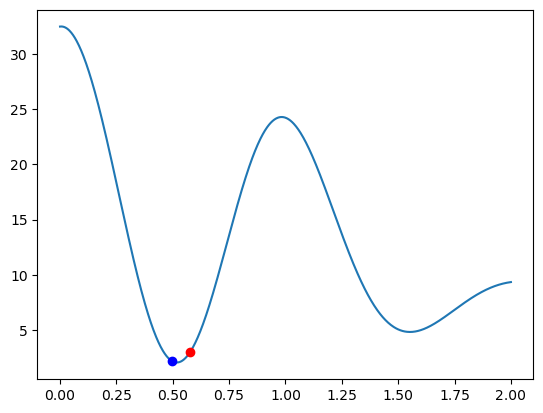

In [174]:
def evolutionary_optimization(population_size, generations):
    """
    Simple implementation of the evolutionary optimization algorith.

    Parameters:
        population_size (int): number of individuals in the population
        generations (int): number of generations to run the algorithm
    """

    # create the initial population
    population = np.random.uniform(start, end, population_size)

    # loop through the generations
    for generation in range(generations):
        # evaluate the population
        population_fitness = [loss_function(x) for x in population]

        # find the best individual
        best_fitness = min(population_fitness)
        best_individual = population[population_fitness.index(best_fitness)]

        # print the best individual
        print(f"Generation {generation}: best individual = {best_individual}, best fitness = {best_fitness}")

        # create the next generation
        next_generation = []

        # keep the best individual
        next_generation.append(best_individual)

        # create the rest of the next generation
        for _ in range(population_size - 1):
            # softmax population_fitness
            population_probs = population_fitness / sum(population_fitness)

            # pick two individuals based on their fitness
            individual_1 = np.random.choice(population, p=population_probs)
            individual_2 = np.random.choice(population, p=population_probs)

            # child is the average of parents
            child = (individual_1 + individual_2) / 2

            # mutation?
            if np.random.uniform(0, 1) < 0.1:
                child += np.random.uniform(-0.1, 0.1)

            # clamp the child to start, end
            child = min(max(start, child), end)

            # append the child
            next_generation.append(child)

        # replace the population with the next generation
        population = next_generation

    return (best_individual, best_fitness)


# run the evolutionary optimization algorithm within our constraints
best_individual, best_fitness = evolutionary_optimization(3, 3)
print("")

# use more resources (100 evaluations)
best_individual2, best_fitness2 = evolutionary_optimization(10, 10)

# plot
plt.plot(x_loss, y_loss)
plt.plot(best_individual, best_fitness, 'ro')
plt.plot(best_individual2, best_fitness2, 'bo')


One of the problems is that genetic algorithms are hard to parallelize. We can parallelize evalutions within a generation, but not across generations as creation of new generations is sequential. Genetic algorithms are usually also quite slow, so this approach is not that popular for hyperparameter optimization, but the logic behind genetic algorithms is used in many scientific fields.

## Bayesian optimization

So, evolutionary approaches are in most cases too time consuming to be practically useful. On the other hand, the main problem with grid search and random search is that they do not use any information from the previous evaluations of $f(x)$, while this allows for easy parallelization it is suboptimal as by probing the loss function we gain information about it. The more information we have, the better we can model the loss function and by facilitating this information we can pick the next hyperparmaeter candidates in a better way. And this is the core idea behind Bayesian optimization. Bayesian optimization uses bayesian modelling to build a surrogate function that tries to mimic the loss function. The more actual measurements we have about how the loss function behaves with regards to hyperparameters, the better we can model it. And the better the model of the loss function, the better our next candidates for hyperparameters can be. What is important is that the surrogate function can be quickly probed, meaning that we can quickly test a number of hyperparameter candidates to find the best one that is then evaluted through the slow and tedious loss function $f(x)$.

The pseudocode for Bayesian optimization looks like this:

```
0. initiate the surrogate function for the loss function.
while n ≤ N do
    1. use the surrogate and acquisition functions to generate a hyperparameter candidate in an informed way
    2. evaluate the candidate
    3. update the surrogate function using the latest evaluation
```

So, surrogate function is our replacement model of the real loss function. Another new term used above is the acquisition function. Acquisition function is the technique by which the surrogate function is used to select the next hyperparameter candidate from the search space.